In [44]:
import numpy as np
import gpflow
from gpflow.param import Param, Parameterized, AutoFlow
from gpflow._settings import settings
import tensorflow as tf
float_type = settings.dtypes.float_type
int_type = settings.dtypes.int_type
np_float_type = np.float32 if float_type is tf.float32 else np.float64

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk", font_scale= 1.4)
%matplotlib inline

In [89]:
tf.concat?

In [90]:
class ExtendRBF1D(gpflow.kernels.Kern):
    """
    Kernel for monotonicity models
    """
    def __init__(self):
        gpflow.kernels.Kern.__init__(self, input_dim = 1, active_dims= [0])
        self.lengthscale = gpflow.param.Param(1.0, transform=gpflow.transforms.positive)
        self.signal_variance = gpflow.param.Param(1.0, transform=gpflow.transforms.positive)
    
    def Kn(self, X1, X2):
        cov = self.signal_variance * tf.exp(-1./(2 * tf.square(self.lengthscale)) * tf.square(X1 - tf.transpose(X2)))
        return cov
    
    def Kd(self, X1, X2):
        """
        Covariance between gaussian process at X2 and its derivative at X1
        """
        cov = (self.signal_variance * 
               tf.exp(-1./(2 * tf.square(self.lengthscale)) * tf.square(X1 - tf.transpose(X2))) *
              (-1./tf.square(self.lengthscale) * (X1 - tf.transpose(X2))))
        return cov
    
    def Kdd(self, X1, X2):
        """
        Covariance between derivatives of gaussian process at X1 and X2
        """
        cov = (self.signal_variance * 
               tf.exp(-1./(2 * tf.square(self.lengthscale)) * tf.square(X1 - tf.transpose(X2)))* 
               1./tf.square(self.lengthscale) *
              (1. - 1./tf.square(self.lengthscale) * tf.square(X1 - tf.transpose(X2))))
        return cov
    
    def K(self, X, X_prime):
        """
        Covariance matrix for joint Normal distribution over GP and its derivative
        """
        K_f_f = self.Kn(X, X)
        K_f_fprime = self.Kd(X, X_prime)
        K_fprime_f = tf.transpose(K_f_fprime)
        K_fprime_fprime = self.Kdd(X_prime, X_prime)
        Knew1 = tf.concat([K_f_f, K_f_fprime], 1)
        Knew2 = tf.concat([K_fprime_f, K_fprime_fprime], 1)
        K_joint = tf.concat([Knew1, Knew2], 0)
        return K_joint 
        
    @AutoFlow((float_type, [None, None]), (float_type, [None, None]))
    def compute_Kn(self, X, Z):
        return self.Kn(X, Z)
    
    @AutoFlow((float_type, [None, None]), (float_type, [None, None]))
    def compute_Kd(self, X, Z):
        return self.Kd(X, Z)
    
    @AutoFlow((float_type, [None, None]), (float_type, [None, None]))
    def compute_Kdd(self, X, Z):
        return self.Kdd(X, Z)
    
    @AutoFlow((float_type, [None, None]), (float_type, [None, None]))
    def compute_K(self, X, X_prime):
        return self.K(X, X_prime)

In [97]:
X = np.array([1,2,3])[:,None]
X_prime = np.array([4,5])[:,None]
K = ExtendRBF1D()
aa = K.compute_K(X, X_prime)

In [67]:
from gpflow.likelihoods import Likelihood
from gpflow.likelihoods import probit
from gpflow import densities

class MonotoneLikelihood(Likelihood):
    def __init__(self):
        """
        Likelihood for Gaussian Process with monotonicity constraints
        """
        Likelihood.__init__(self)
        self.nu = 1e-6
        self.signal_variance = Param(1.0, transforms.positive)
    
    def logp_ygf(self, F, Y):
        return tf.reduce_sum(densities.gaussian(F, Y, self.signal_variance))
    
    def logp_m(self, F_prime, invlink = probit):
        Y = tf.ones(tf.shape(F_prime).shape.as_list(), tf.int32) 
        return tf.reduce_sum(densities.bernoulli(self.invlink(1./self.nu*F_prime), Y))
    
    def logp(F, Y, F_prime):
        log_like_ygp = self.logp_ygf(F, Y)
        log_like_m = self.logpm(F_prime, invlink = probit)
        log_like = log_like_ygp + log_like_m
        return log_like    

In [69]:
from gpflow.mean_functions import Zero
from gpflow.param import Parameterized, AutoFlow, DataHolder

class MonotoneGP(gpflow.model.Model):
    def __init__(self, X_concat, Y, name = 'monotonic_model'):
        """
        X_concat is a data vector, size (N + M) x 1
        X_concat = (X, X_der_loc)
        Y is a data matrix, size N x 1 
    
        This is a vanilla implementation of a GP with monotonicity contraints.
        
        Refer:
        https://bayesopt.github.io/papers/2017/9.pdf
        
        """
        if not X_concat.shape[1] == 1:
            raise ValueError('Currently, GP with monotonicity is only supported for 1D')
        
        # Initialize the model
        gpflow.Model.__init__(self, name)
        # Zero mean function for now
        self.mean_function = Zero()
        
        # Initialize data
        if isinstance(X_concat, np.ndarray):
            #: X is a data matrix; each row represents one instance
            X_concat = DataHolder(X_concat)
        if isinstance(Y, np.ndarray):
            #: Y is a data matrix, rows correspond to the rows in X, columns are treated independently
            Y = DataHolder(Y)
        
        # Define kernel
        self.kern = ExtendRBF1D()
        
        # Define likelihood 
        self.likelihood = MonotoneLikelihood()
        self.likelihood._check_targets(Y.value)
        
        # Initialize
        self.Y = Y
        self.X_concat = X_concat
        
        self._session = None
    
    def build_predict(self, *args, **kwargs):
        raise NotImplementedError

    @AutoFlow((float_type, [None, None]))
    def predict_f(self, Xnew):
        """
        Compute the mean and variance of the latent function(s)
        at the points `Xnew`.
        """
        return self.build_predict(Xnew)

    @AutoFlow((float_type, [None, None]))
    def predict_f_full_cov(self, Xnew):
        """
        Compute the mean and covariance matrix of the latent function(s) at the
        points Xnew.
        """
        return self.build_predict(Xnew, full_cov=True)

    @AutoFlow((float_type, [None, None]), (tf.int32, []))
    def predict_f_samples(self, Xnew, num_samples):
        """
        Produce samples from the posterior latent function(s) at the points
        Xnew.
        """
        mu, var = self.build_predict(Xnew, full_cov=True)
        jitter = tf.eye(tf.shape(mu)[0], dtype=float_type) * settings.numerics.jitter_level
        samples = []
        for i in range(self.num_latent):
            L = tf.cholesky(var[:, :, i] + jitter)
            shape = tf.stack([tf.shape(L)[0], num_samples])
            V = tf.random_normal(shape, dtype=settings.dtypes.float_type)
            samples.append(mu[:, i:i + 1] + tf.matmul(L, V))
        return tf.transpose(tf.stack(samples))

    @AutoFlow((float_type, [None, None]))
    def predict_y(self, Xnew):
        """
        Compute the mean and variance of held-out data at the points Xnew
        """
        pred_f_mean, pred_f_var = self.build_predict(Xnew)
        return self.likelihood.predict_mean_and_var(pred_f_mean, pred_f_var)

    @AutoFlow((float_type, [None, None]), (float_type, [None, None]))
    def predict_density(self, Xnew, Ynew):
        """
        Compute the (log) density of the data Ynew at the points Xnew

        Note that this computes the log density of the data individually,
        ignoring correlations between them. The result is a matrix the same
        shape as Ynew containing the log densities.
        """
        pred_f_mean, pred_f_var = self.build_predict(Xnew)
        return self.likelihood.predict_density(pred_f_mean, pred_f_var, Ynew)

In [ ]:
from gpflow.priors import Gaussian
class MonotoneGPMC(MonotoneGP):
    def __init__(self, X, Y, X_prime, num_latent = None):
        """
        X is a data vector, size N x 1
        X_prime is a vector, size M x 1
        Y is a data matrix, size N x 1 
    
        This is a vanilla implementation of a GP with monotonicity contraints and HMC sampling
        Refer:
        https://bayesopt.github.io/papers/2017/9.pdf
        """
        X_concat = np.vstack([X, X_prime])
        X_concat = DataHolder(X_concat, on_shape_change='recompile')
        Y = DataHolder(Y, on_shape_change='recompile')
        MonotoneGP.__init__(self, X_concat, Y)
        self.num_data = X_concat.shape[0]
        self.num_x_points = X.shape[0]
        self.num_der_points = X_prime.shape[0]
        self.num_latent = num_latent or Y.shape[1]
        self.V = Param(np.zeros((self.num_data, self.num_latent)))
        self.V.prior = Gaussian(0., 1.)
    def compile(self, session = None, graph = None, optimizer = None):
        """
        Before calling the standard compile function, check to see if the size
        of the data has changed and add parameters appropriately.

        This is necessary because the shape of the parameters depends on the
        shape of the data.
        """
        if not self.num_data == self.X_concat.shape[0]:
            self.num_data = self.X_concat.shape[0]
            self.V = Param(np.zeros((self.num_data, self.num_latent)))
            self.V.prior = Gaussian(0., 1.)
        
        return super(MonotoneGPMC, self).compile(session = session,
                                                 graph = graph,
                                                 optimizer = optimizer)
    
    def build_likelihood(self):
        K = self.kern.K(self.X)
        L = tf.cholesky(K + tf.eye(tf.shape(self.X)[0], dtype=float_type)*settings.numerics.jitter_level)
        F_concat = tf.matmul(L, self.V) + self.mean_function(self.X)
        F, F_prime = tf.split(F_concat, [self.num_x_points, self.num_der_points])
        log_like = self.likelihood.logp(F, self.Y, F_prime)
        return log_like
    
    def build_predict(self, Xnew, full_cov=False):
        """
        Xnew is a data matrix, point at which we want to predict

        This method computes

            p(F* | (F=LV) )

        where F* are points on the GP at Xnew, F=LV are points on the GP at X.

        """
        
        raise ValueError("Under construction")
        
        mu, var = conditional(Xnew, self.X, self.kern, self.V,
                              full_cov=full_cov,
                              q_sqrt=None, whiten=True)
        return mu + self.mean_function(Xnew), var


In [103]:
X = np.linspace(0, 1, 10)
X_der = np.linspace(0,1, 50)
Y = 5 * X 

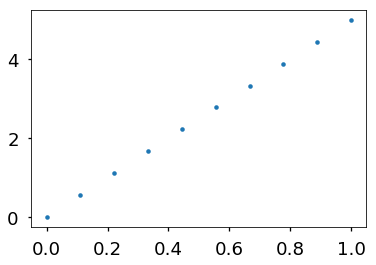

In [105]:
plt.plot(X, Y, '.')

In [100]:
@NameScoped("conditional")
def conditional(Xnew, X, kern, f, full_cov=False, q_sqrt=None, whiten=False):
    """
    Given F_concat, representing the GP at the points X,
    produce the mean and (co-)variance of the GP at the points Xnew.

    Additionally, there may be Gaussian uncertainty about F as represented by
    q_sqrt. In this case `f` represents the mean of the distribution and
    q_sqrt the square-root of the covariance.

    Additionally, the GP may have been centered (whitened) so that
        p(v) = N( 0, I)
        f = L v
    thus
        p(f) = N(0, LL^T) = N(0, K).
    In this case 'f' represents the values taken by v.

    The method can either return the diagonals of the covariance matrix for
    each output of the full covariance matrix (full_cov).

    We assume K independent GPs, represented by the columns of f (and the
    last dimension of q_sqrt).

     - Xnew is a data matrix, size N x D
     - X are data points, size M x D
     - kern is a GPflow kernel
     - f is a data matrix, M x K, representing the function values at X, for K functions.
     - q_sqrt (optional) is a matrix of standard-deviations or Cholesky
       matrices, size M x K or M x M x K
     - whiten (optional) is a boolean: whether to whiten the representation
       as described above.

    These functions are now considered deprecated, subsumed into this one:
        gp_predict
        gaussian_gp_predict
        gp_predict_whitened
        gaussian_gp_predict_whitened

    """

    # compute kernel stuff
    num_data = tf.shape(X)[0]  # M
    num_func = tf.shape(f)[1]  # K
    Kmn = kern.K(X, Xnew)
    Kmm = kern.K(X) + tf.eye(num_data, dtype=float_type) * settings.numerics.jitter_level
    Lm = tf.cholesky(Kmm)

    # Compute the projection matrix A
    A = tf.matrix_triangular_solve(Lm, Kmn, lower=True)

    # compute the covariance due to the conditioning
    if full_cov:
        fvar = kern.K(Xnew) - tf.matmul(A, A, transpose_a=True)
        shape = tf.stack([num_func, 1, 1])
    else:
        fvar = kern.Kdiag(Xnew) - tf.reduce_sum(tf.square(A), 0)
        shape = tf.stack([num_func, 1])
    fvar = tf.tile(tf.expand_dims(fvar, 0), shape)  # K x N x N or K x N

    # another backsubstitution in the unwhitened case
    if not whiten:
        A = tf.matrix_triangular_solve(tf.transpose(Lm), A, lower=False)

    # construct the conditional mean
    fmean = tf.matmul(A, f, transpose_a=True)

    if q_sqrt is not None:
        if q_sqrt.get_shape().ndims == 2:
            LTA = A * tf.expand_dims(tf.transpose(q_sqrt), 2)  # K x M x N
        elif q_sqrt.get_shape().ndims == 3:
            L = tf.matrix_band_part(tf.transpose(q_sqrt, (2, 0, 1)), -1, 0)  # K x M x M
            A_tiled = tf.tile(tf.expand_dims(A, 0), tf.stack([num_func, 1, 1]))
            LTA = tf.matmul(L, A_tiled, transpose_a=True)  # K x M x N
        else:  # pragma: no cover
            raise ValueError("Bad dimension for q_sqrt: %s" %
                             str(q_sqrt.get_shape().ndims))
        if full_cov:
            fvar = fvar + tf.matmul(LTA, LTA, transpose_a=True)  # K x N x N
        else:
            fvar = fvar + tf.reduce_sum(tf.square(LTA), 1)  # K x N
    fvar = tf.transpose(fvar)  # N x K or N x N x K

    return fmean, fvar

In [55]:
t = tf.constant([[[1, 1, 1], [2, 2, 2]], [[3, 3, 3], [4, 4, 4]]])
a = tf.shape(t)  # [2, 2, 3]

In [59]:
a.shape.as_list()

[3]

In [65]:
a.shape.as_list()

<bound method TensorShape.as_list of TensorShape([Dimension(3)])>

In [74]:
a = np.eye(2)
c = np.eye(2)

In [75]:
b = DataHolder(a)
d = DataHolder(c)

In [88]:
type(g)

NoneType

In [87]:
r = tf.concat(values = [g, f], axis = 1)

TypeError: Tensors in list passed to 'values' of 'ConcatV2' Op have types [<NOT CONVERTIBLE TO TENSOR>, <NOT CONVERTIBLE TO TENSOR>] that don't all match.

In [81]:
tf.concat?

In [96]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [98]:
is_pos_def(aa)

True